# **CIS 545 Final Project Notebook**

## Author

**Yung-Tang Chou**. PennID: *86903286*  
**Yung-Jen Yang**.  &ensp;&thinsp;PennID: *65314711*

# **Project Introduction**

## **Project Background**

We want to predict genre of the song based on audio features and lyrics of the song. We will implement some NLP techniques to deal with lyrics. This will be a multiclass classification problem with 12 differnent labels. 

```python
['USA_Blues', 'USA_Christian & Gospel', 'USA_Country', 'USA_Folk & Acoustic', 'USA_Funk & Disco', 'USA_Hip-Hop', 'USA_Jazz', 'USA_Metal', 'USA_Pop', 'USA_R&B', 'USA_Rock', 'USA_Romance']
```

**Note**: Label is chosen based on actual genre instead of ~vibes or emotions~.

## **Data Source**

- **Playlist information / label**: Spotify API

- **Audio information**: Spotify API

- **Lyrics**: Web crawler + genius API

## **Table of Contents**

- Import Packages

- Part 1: Data Gathering
  - 1.1 Get spotify playlist data via Spotify API
  - 1.2 Get spotify audio data via Spotify API
  - 1.3 Get lyrics for each song using web crawler + API
  - 1.4 Load Files from CSV

- Part 2: Exploratory Analysis
  - 2.1 Distribution
  - 2.2 Box Plot
  - 2.3 Heatmap

- Part 3: Feature Engineering
  - 3.1 Audio-related features
    - 3.1.1 Create Feature for Tempo
    - 3.1.2 Transform Key and Mode to Categorical Features
    - 3.1.3 Add indicator columns for missing Columns
    - 3.1.4 Create dataframe for later modeling
  - 3.2 Text-related Features
    - 3.2.1 Data cleaning with regular expression
    - 3.2.2 Create indicator column for missing lyrics
    - 3.2.3 Get sentiment using Texblob
    - 3.2.4 Get topic modeling using Latent Dirichlet Allocation
    - 3.2.5 Text-related features
  - 3.3 Missing value imputation

- Part 4: Modeling
  - 4.1 Define Evaluation Function
  - 4.2 Baseline Model
  - 4.3 Add in Sentiment Analysis
  - 4.4 Add in Topic Modeling
  - 4.5 Impute Missing Value

- Part 5: Comparison

- Final Summary

- Reference

# **Code Section**

## **Import Packages**

In [ ]:
!pip install pandasql miceforest lyricsgenius scipy==1.7.1

In [ ]:
## data collection
import lyricsgenius
import base64
import datetime
from urllib.parse import urlencode
import requests
from bs4 import BeautifulSoup
import re
from google.colab import drive


## data wrangling
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

## classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, top_k_accuracy_score

## text modeling
import spacy
import gensim
import warnings
from textblob import TextBlob
import scipy
import scipy.stats as ss
from sklearn.feature_extraction.text import CountVectorizer

## missing value imputation
import miceforest as mf

%matplotlib inline
warnings.filterwarnings('ignore')

## **Part 1: Data Gathering**

### **1.1 Get spotify playlist data via Spotify API**

Code is commented since we already collected the data in .csv format. Will load in the file directly.

**Note**: Do not run this cell unless you want to use the API.

In [ ]:
# class SpotifyAPI(object):
#     access_token = None
#     access_token_expires = datetime.datetime.now()
#     access_token_did_expire = True
#     client_id = None
#     client_secret = None
#     token_url = "https://accounts.spotify.com/api/token"
    
#     def __init__(self, client_id, client_secret, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.client_id = client_id
#         self.client_secret = client_secret

#     def get_client_credentials(self):
#         """
#         Returns a base64 encoded string
#         """
#         client_id = self.client_id
#         client_secret = self.client_secret
#         if client_secret == None or client_id == None:
#             raise Exception("You must set client_id and client_secret")
#         client_creds = f"{client_id}:{client_secret}"
#         client_creds_b64 = base64.b64encode(client_creds.encode())
#         return client_creds_b64.decode()
    
#     def get_token_headers(self):
#         client_creds_b64 = self.get_client_credentials()
#         return {
#             "Authorization": f"Basic {client_creds_b64}"
#         }
    
#     def get_token_data(self):
#         return {
#             "grant_type": "client_credentials"
#         } 
    
#     def perform_auth(self):
#         token_url = self.token_url
#         token_data = self.get_token_data()
#         token_headers = self.get_token_headers()
#         r = requests.post(token_url, data=token_data, headers=token_headers)
#         if r.status_code not in range(200, 299):
#             raise Exception("Could not authenticate client.")
#             # return False
#         data = r.json()
#         now = datetime.datetime.now()
#         access_token = data['access_token']
#         expires_in = data['expires_in'] # seconds
#         expires = now + datetime.timedelta(seconds=expires_in)
#         self.access_token = access_token
#         self.access_token_expires = expires
#         self.access_token_did_expire = expires < now
#         return True
    
#     def get_access_token(self):
#         token = self.access_token
#         expires = self.access_token_expires
#         now = datetime.datetime.now()
#         if expires < now:
#             self.perform_auth()
#             return self.get_access_token()
#         elif token == None:
#             self.perform_auth()
#             return self.get_access_token() 
#         return token
    
#     def get_resource_header(self):
#         access_token = self.get_access_token()
#         headers = {
#             "Authorization": f"Bearer {access_token}"
#         }
#         return headers
        
        
#     def get_resource(self, lookup_id, resource_type='albums', version='v1'):
#         endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
#         headers = self.get_resource_header()
#         r = requests.get(endpoint, headers=headers)
#         if r.status_code not in range(200, 299):
#             return {}
#         return r.json()
    
#     def get_album(self, _id):
#         return self.get_resource(_id, resource_type='albums')
    
#     def get_artist(self, _id):
#         return self.get_resource(_id, resource_type='artists')

#     def get_playlist(self, _id):
#         return self.get_resource(_id, resource_type='playlists')

#     def get_track_aduio_feature(self, _id):
#         return self.get_resource(_id, resource_type='audio-features')
    
#     def get_track(self, _id):
#         return self.get_resource(_id, resource_type='tracks')
    
#     def get_audio_analysis(self, _id):
#         return self.get_resource(_id, resource_type='audio-analysis')
    
#     def base_search(self, query_params): # type
#         headers = self.get_resource_header()
#         endpoint = "https://api.spotify.com/v1/search"
#         lookup_url = f"{endpoint}?{query_params}"
#         r = requests.get(lookup_url, headers=headers)
#         if r.status_code not in range(200, 299):  
#             return {}
#         return r.json()
    
#     def search(self, query=None, operator=None, operator_query=None, search_type='artist' ):
#         if query == None:
#             raise Exception("A query is required")
#         if isinstance(query, dict):
#             query = " ".join([f"{k}:{v}" for k,v in query.items()])
#         if operator != None and operator_query != None:
#             if operator.lower() == "or" or operator.lower() == "not":
#                 operator = operator.upper()
#                 if isinstance(operator_query, str):
#                     query = f"{query} {operator} {operator_query}"
#         query_params = urlencode({"q": query, "type": search_type.lower()})
#         print(query_params)
#         return self.base_search(query_params)


In [ ]:
# client_id = '997d633742834b638993d98b0864e20f'
# client_secret = '1bb2f372e94e4600b335557c5eb6947e'
# spotify = SpotifyAPI(client_id, client_secret)

In [ ]:
# def get_total_playlist_id(url):
#     res = requests.get(url)
#     total_playlist_id = {}
#     soup = BeautifulSoup(res.text, 'lxml')
#     countryName_list = soup.find_all('div', attrs={'class': 'countryname'})
#     totalPlaylist = soup.find_all('div', attrs={'class': 'playlists'})
#     for genre, playlist in zip(countryName_list, totalPlaylist):
#         genre_name = genre.text.split('/')[0].strip() + '_' + genre.text.split('/')[1].strip()
#         playlist = [x for x in list(playlist) if x != '\n']
#         playlist_id = []
#         for ele in playlist[:-1]:
#             reg = r'"spotify:playlist:(.*?)"'
#             ele = str(ele).strip()
#             m = re.search(reg, ele)
#             playlist_id.append(m.group(1)) 
    
#         total_playlist_id[genre_name] = playlist_id

#     return total_playlist_id

In [ ]:
# def update_playlist_info(playlist_id, info, genre):
#     playlist_data = spotify.get_playlist(playlist_id)
#     length = len(playlist_data['tracks']['items'])
#     for i in range(length):
#         info['genre'].append(genre)
#         info['playlist_id'].append(playlist_id)
#         try:
#             playlist_subGenre = playlist_data['name']
#             info['playlist_subGenre'].append(playlist_subGenre)
#         except:
#             info['playlist_subGenre'].append(None)
    
#         try:
#             track_name = playlist_data['tracks']['items'][i]['track']['name']
#             info['track_name'].append(track_name)
#         except:
#             info['track_name'].append(None)
    
#         try:
#             artist_name = playlist_data['tracks']['items'][i]['track']['artists'][0]['name']
#             info['artist_name'].append(artist_name)
#         except:
#             info['artist_name'].append(None)
    
#         try:
#             album_name = playlist_data['tracks']['items'][i]['track']['album']['name']
#             info['album_name'].append(album_name)
#         except:
#             info['album_name'].append(None)
    
#         try:
#             track_id = playlist_data['tracks']['items'][i]['track']['id'] 
#             info['track_id'].append(track_id)
#         except:
#             info['track_id'].append(None)
    
#         try:
#             artist_id = playlist_data['tracks']['items'][i]['track']['artists'][0]['id']
#             info['artist_id'].append(artist_id)
#         except:
#             info['artist_id'].append(None)
    
#         try:
#             album_id = playlist_data['tracks']['items'][i]['track']['album']['id'] 
#             info['album_id'].append(album_id)
#         except:
#             info['album_id'].append(None)

In [ ]:
# playlist_info = {'genre': [], 'playlist_subGenre': [], 'track_name': [], 'artist_name': [], 'album_name': [], 'track_id': [], 'artist_id': [], 'album_id': [], 'playlist_id': []}
# url = 'https://everynoise.com/worldbrowser.cgi?country=US'
# total_playlist_id = get_total_playlist_id(url)

# for genre, playlist_id_list in total_playlist_id.items():
#     for playlist_id in playlist_id_list:
#         update_playlist_info(playlist_id, playlist_info, genre)


In [ ]:
# playlist_df = pd.DataFrame(playlist_info)
# playlist_df.to_csv('playlist_info.csv', index=False)

### **1.2 Get spotify audio data via Spotify API**

Code is commented since we already collected the data in .csv format. Will load in the file directly.

**Note**: Do not run this cell unless you want to use the API.

In [ ]:
# audio_df = pd.DataFrame()
# track_id_list = playlist_df['track_id'].tolist()
# for track_id in track_id_list:
#     audio_info = spotify.get_track_aduio_feature(track_id)
#     tmp_di = {'track_id': track_id}
#     tmp_di.update(audio_info)
    
#     audio_df = audio_df.append(tmp_di, ignore_index=True)    

In [ ]:
# tmp_di = {'track_id': [], 'popularity':[], 'pitches': [], 'timbre': []}
# for id in track_id_list:
#     tmp_di['track_id'].append(id)
#     try:
#         popu = spotify.get_track(id)['popularity']
#         tmp_df['popularity'].append(popu)
#     except:
#         tmp_df['popularity'].append(None)
#     try:
#         pitches = spotify.get_audio_analysis(id)['segments'][0]['pitches']
#         tmp_di['pitches'].append(pitches)
#     except:
#         tmp_di['pitches'].append(None)
#     try:
#         timbre = spotify.get_audio_analysis(id)['segments'][0]['timbre']
#         tmp_di['timbre'].append(timbre)
#     except:
#         tmp_di['timbre'].append(None)
    
# analysis_df = pd.DataFrame(tmp_di)


In [ ]:
# query = """
# WITH m2 AS (SELECT a.*, m.popularity, m.pitches, m.timbre FROM audio_df AS a LEFT JOIN analysis_df AS m ON m.track_id = a.track_id)
# SELECT * FROM m2
# """

# audio_df = ps.sqldf(query, locals())
# audio_df.to_csv('audio_info.csv', index=False)

### **1.3 Get lyrics for each song using web crawler + API**

Code is commented since we already collected the data in .csv format. Will load in the file directly.

**Note**: Do not run this cell unless you want to use the API.

In [ ]:
# token = 'xMNfQSwE11u2pqljsPDLO8RLEkeVANh1GbYKbuusL2EJiwum5DgHMSQRnGpBgHHO'
# genius = lyricsgenius.Genius(token)

In [ ]:
# track_list = list(playlist_df['track_name'])
# artist_list = list(playlist_df['artist_name'])
# track_id_list = list(playlist_df['track_id'])
# lyr_dict = {'track_name': [], 'artist_name': [], 'lyrics': [], 'track_id': []}

In [ ]:
# for track_name, artist_name, track_id in zip(track_list, artist_list, track_id_list):
#     lyr_dict['track_name'].append(track_name)
#     lyr_dict['artist_name'].append(artist_name)
#     lyr_dict['track_id'].append(track_id)
#     try:
#         song = genius.search_song(track_name, artist_name)
#         if song == None:
#             lyr_dict['lyrics'].append(None)
#             continue
#         lyr_dict['lyrics'].append(song.lyrics)
#     except:
#         lyr_dict['lyrics'].append(None)

In [ ]:
# lyrics_df = pd.DataFrame(lyr_dict)
# lyrics_df.to_csv('lyrics_info.csv', index=False)

### **1.4 Load Files from CSV**

Dataset is collected using the code above. We will simply load in the existing file and join the dataset together.

To load in the data using the code below, please follow the following steps.

1. Visit this [google drive link](https://drive.google.com/drive/folders/1icC2-0VfWNgLEC4idHcD0RTmpbCMk7Ta?usp=sharing) and copy this folder to on your google drive (directly on MyDrive).

2. After you run the **drive.mount()** code below, the google SSO page will pop up. Choose the account that you put the files in. 

3. After mounting (the previous step), you should be able to run the code!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
playlist_df = pd.read_csv('/content/gdrive/MyDrive/CIS 545 Project Files/playlist.csv')
audio_df = pd.read_csv('/content/gdrive/MyDrive/CIS 545 Project Files/audio.csv')
popularity_df = pd.read_csv('/content/gdrive/MyDrive/CIS 545 Project Files/popularity.csv')
lyrics_df = pd.read_csv('/content/gdrive/MyDrive/CIS 545 Project Files/lyrics.csv')

In [ ]:
## Get dataframe from pandasql
query = """
SELECT DISTINCT p.genre, p.track_id, a.duration_ms, a.acousticness, a.danceability, a.energy, 
a.instrumentalness, a.key, a.liveness, a.loudness, a.mode, a.speechiness, a.tempo, a.time_signature, a.valence,
b.popularity, b.pitches, b.timbre
FROM playlist_df AS p 
LEFT JOIN audio_df AS a ON p.track_id = a.track_id
LEFT JOIN popularity_df AS b ON p.track_id = b.track_id
"""
df = ps.sqldf(query, locals())

## Filter by the genres for later analysis
genres = ['USA_Blues', 'USA_Christian & Gospel', 'USA_Country', 'USA_Folk & Acoustic', 
          'USA_Funk & Disco', 'USA_Hip-Hop', 'USA_Jazz', 'USA_Metal', 'USA_Pop', 
          'USA_R&B', 'USA_Rock', 'USA_Romance']
df = df[df['genre'].isin(genres)].dropna(subset = df.columns[:-3]).drop_duplicates().reset_index(drop=True)

In [ ]:
## Drop duplicate values
df = df.drop_duplicates(subset = ['track_id', 'genre'])

## Drop tracks that have duplicated labels
val_counts = df['track_id'].value_counts()
idx_to_drop = val_counts[val_counts >= 2].index

df = df[~df['track_id'].isin(idx_to_drop)].reset_index(drop = True)

## **Part 2: Exploratory Analysis**

In this section, we will examine the data at hand by several data visualization techniques.


### **2.1 Distribution**

In [ ]:
eda_df = df.copy()
eda_df

,genre,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,pitches,timbre
0,USA_Hip-Hop,40iJIUlhi6renaREYGeIDS,291175.0,0.05030,0.666,0.465,0.000000,1.0,0.2150,-8.545,1.0,0.2600,167.937,4.0,0.292,NaN,None,None
1,USA_Hip-Hop,08F16baYbciTva9P4BvpiI,240000.0,0.07750,0.855,0.492,0.000007,0.0,0.1110,-7.578,0.0,0.0483,109.975,4.0,0.385,NaN,None,None
2,USA_Hip-Hop,7Bpx2vsWfQFBACRz4h3IqH,252070.0,0.00575,0.711,0.611,0.000000,1.0,0.2310,-5.453,1.0,0.3290,134.140,4.0,0.144,NaN,None,None
3,USA_Hip-Hop,4c7LkE1lSNj3RR4cZo0jEi,133631.0,0.01070,0.772,0.563,0.000000,11.0,0.3040,-8.188,0.0,0.4520,160.064,4.0,0.521,NaN,None,None
4,USA_Hip-Hop,5qyZ6LcHvBiIHLaoED8K4g,150527.0,0.00194,0.773,0.623,0.000000,2.0,0.1330,-5.267,1.0,0.1960,153.100,4.0,0.130,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28241,USA_Funk & Disco,3HFdPsHeAtmIrCz5fOYnp4,191787.0,0.27100,0.833,0.806,0.000001,4.0,0.1590,-7.439,1.0,0.0463,112.230,4.0,0.841,33.0,"[1.0, 0.935, 0.276, 0.265, 0.183, 0.187, 0.176...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
28242,USA_Funk & Disco,08FgxyV1J0a0DzSaCqvbdp,181440.0,0.07370,0.743,0.827,0.000000,5.0,0.0544,-12.040,1.0,0.0544,143.818,4.0,0.831,0.0,"[1.0, 0.747, 0.58, 0.398, 0.365, 0.362, 0.457,...","[0.012, 170.923, 8.979, -28.775, 57.05, -50.16..."
28243,USA_Funk & Disco,4tY01qYozc6db4gihAiIl8,199800.0,0.13700,0.529,0.722,0.000479,3.0,0.2120,-10.241,1.0,0.0682,126.356,4.0,0.252,NaN,None,None
28244,USA_Funk & Disco,3YJx77Xx8JSwEoxqrkQO5c,189840.0,0.27700,0.864,0.346,0.005210,4.0,0.0514,-12.918,1.0,0.0365,105.164,4.0,0.964,NaN,None,None


In [ ]:
## Convert key(number) to actual normal expression(C,D,E ....) 
eda_df['key'] = eda_df['key'].astype(int)

## Referenced by the Spotify API.
key_dict = {0: "C", 1 :"C♯/D♭", 2:"D", 3:"D#/E♭", 4:"E", 5:"F", 6:"F#/G♭",7:"G",8:"G#/A♭",9:"A",10:"A#/B♭",11:"B"}
eda_df['key_note'] = eda_df['key'].apply(lambda x: key_dict[x])

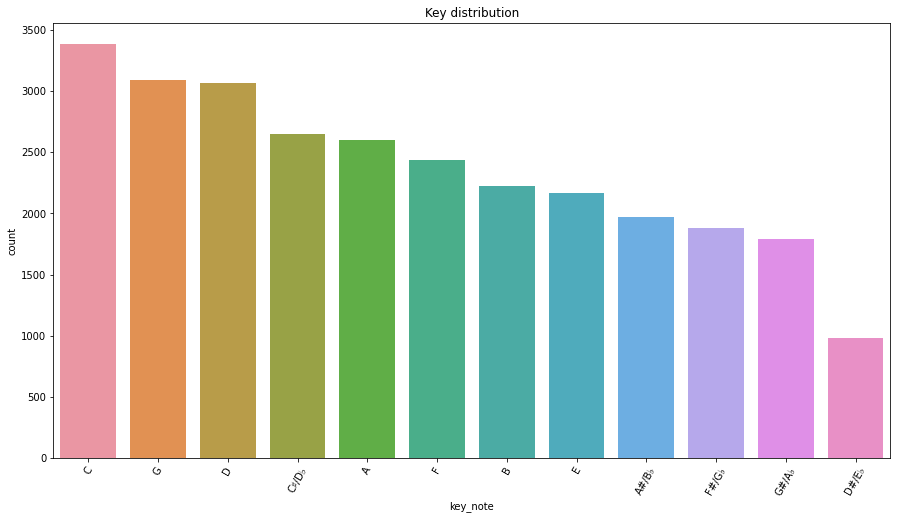

In [ ]:
## Plot the distribution of keys.

plt.figure(figsize=(15,8))
ax = sns.countplot(x='key_note', data=eda_df, order=eda_df['key_note'].value_counts().index)
ax.tick_params(axis='x', rotation=60)
plt.title('Key distribution')
plt.show()

From the key distribution plot, we can see  
C is used most, while D#/Eb is used least.  

From my perspective, this distribution makes sense.  
If you had learned the theory of music. D#/Eb is not a common key no matter in classic music or in modern music because D#/Eb key typically brings sad emotion to audience,  

A big part of reason that C, G, D have become the mainstream key is that songs are easily produced based on these keys and easily accepted by audience.  


In [ ]:
## statistic of duration

eda_df['duration_min'] = eda_df['duration_ms'].apply(lambda x: x/1000/60)
eda_df['duration_min'].describe()

count    28246.000000
mean         3.943783
std          1.327260
min          0.517783
25%          3.114142
50%          3.688475
75%          4.448933
max         28.449550
Name: duration_min, dtype: float64

<Figure size 1080x576 with 0 Axes>

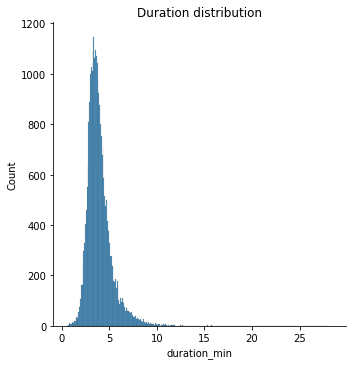

In [ ]:
## Plot distribution of duration (unit: min) among all of the songs.

plt.figure(figsize=(15,8))
sns.displot(eda_df['duration_min'])
plt.title('Duration distribution')
plt.show()

To some extent, we can drop the outliers in which the duration of songs exceeds than 10 mins.  
By doing so, the performance of our model may improve.  

From my personal speculation, those songs which have 10 mins more duration are some playground music without any lyrics from games or advertisements, etc  
By some points, Spotify mislabeled these songs into the wrong playlist.

In [ ]:
def create_binning_for_tempo(x):
    """
    Create binnning rules for different range of tempo based on actual definition in music
    """
    if x <= 60:
        return 'Lento'
    elif x <= 90:
        return 'Moderato'
    elif x <= 120:
        return 'Allegretto'
    elif x <= 168:
        return 'Allegro'
    else:
        return 'Presto'

eda_df['tempo_range'] = eda_df['tempo'].apply(create_binning_for_tempo)

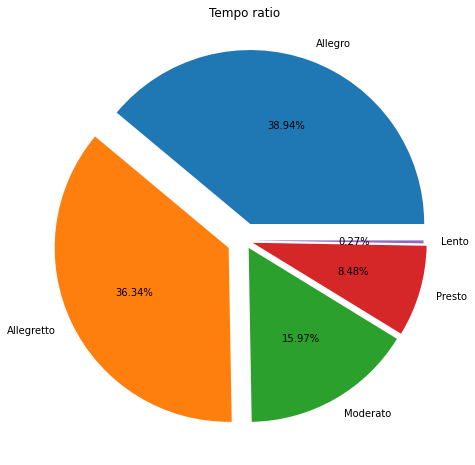

In [ ]:
## The ratio of each tempo among all of the songs

piex = eda_df['tempo_range'].unique()
piey = eda_df['tempo_range'].value_counts().tolist()
plt.figure(figsize=(15,8))
plt.pie(piey, labels=piex, explode=[0.1, 0.1, 0.05, 0.05, 0.03], autopct='%.2f%%')
plt.title('Tempo ratio')
plt.show()

From this pie chart, we can see  
Allegro and Allegretto account for almost two third of songs.  
Lento only account for 0.27%  



### **2.2 Box Plot**

Use Box plot to see the variation of duration in each genre

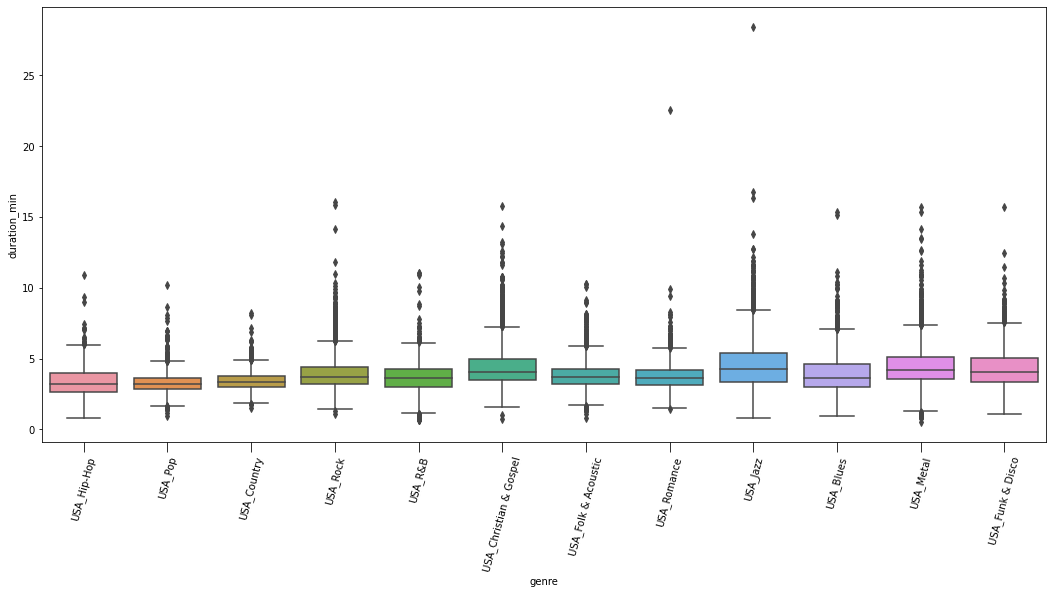

In [ ]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x='genre', y='duration_min', data=eda_df)
ax.tick_params(axis='x',rotation=75, size=10)
plt.show()

From this box plot, we can see  
The average duration range of each genre is between 3 ~ 5 mins.  
Jazz has a little bit longer in average duration and a large duration range.  

There are two extreme outliers in Jazz and Romance.  
Sometimes, it's better to drop these extreme outliers so that our model will become more accurate.

### **2.3 Heatmap**

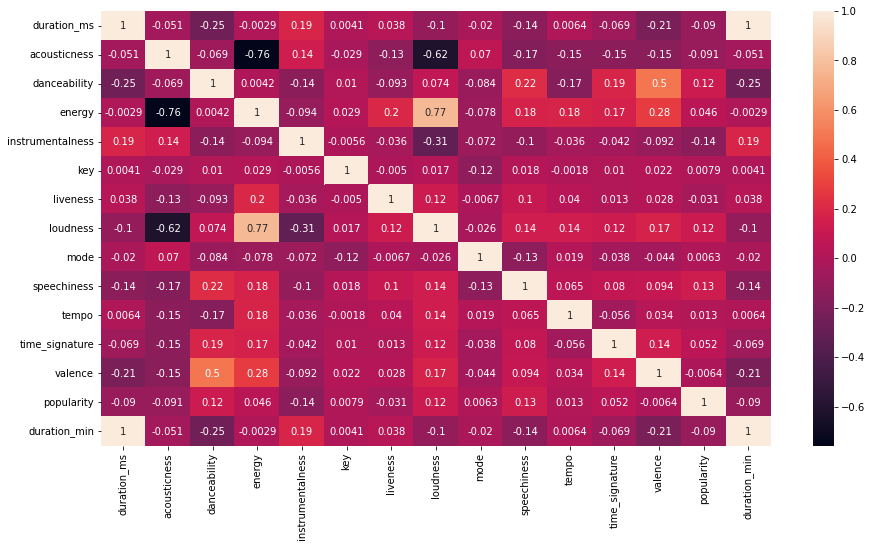

In [ ]:
## correlation bwteen features

plt.figure(figsize=(15,8))
sns.heatmap(eda_df.corr(), annot=True)
plt.show()

From the correlation heatmap,  
Energy and loudness are the most highly correlated(positive correlation)  
Energy and acousticness are also high correlated(negative correlation)

The main purpose of the correlation heatmap is to find there is multicollinearity among all of the features.  
If there are many highly correlated features, we can do PCA to reduce the dimension (using variance ratio to find the optimal dimension, typically we would choose 95% of variance ratio as a boundary)



## **Part 3: Feature Engineering**

In this section, we will conduct feature engineering for later modeling. We will do analysis based on 1) audio features, 2) text features, 3) missing value imputation.

### **3.1 Audio-related features**

First, we will do some analysis on the audio features. These features are extracted from spotify API, and showcase the characteristics of each song.

#### **3.1.1 Create Feature for Tempo**

Based on domain knowledge, we can bin the tempo into several groups.

In [ ]:
def create_binning_for_tempo(x: int) -> str:
    """
    Create binnning rules for different range of tempo based on actual definition in music.

    Parameters
    --------
    x: int, value for temp

    Output
    --------
    str, name of the tempo
    """
    if x <= 60:
        return 'Lento'
    elif x <= 90:
        return 'Moderato'
    elif x <= 120:
        return 'Allegretto'
    elif x <= 168:
        return 'Allegro'
    else:
        return 'Presto'

df['tempo_range'] = df['tempo'].apply(create_binning_for_tempo)

#### **3.1.2 Transform Key and Mode to Categorical Features**

Key and mode, based on the Spotify API documentation, are categorical features rather than numerical values. Therefore, we transform these numbers to the values they belong to.

In [ ]:
def transform_label_to_value(series: pd.Series, dic: dict) -> pd.Series:
    """
    Transform label to values based on the dictionary fed into.

    Parameters
    --------
    series: pd.Series, series to transform
    dic: dictionary, mapping rule

    Output
    --------
    series: pd.Series, transformed series
    """
    series = series.astype(int)
    series = series.apply(lambda x: dic[x])
    return series

## transform key
key_dict = {0: "C", 1 :"C♯/D♭", 2:"D", 3:"D#/E♭", 4:"E", 5:"F", 6:"F#/G♭",7:"G",8:"G#/A♭",9:"A",10:"A#/B♭",11:"B"}
df['key'] = transform_label_to_value(df['key'], key_dict)

## transofrm mode
mode_dict = {1: 'major', 0: 'minor'}
df['mode'] = transform_label_to_value(df['mode'], mode_dict)

#### **3.1.3 Add indicator columns for missing Columns**

Missing values of each song's popularity, pitches, and timbre may provide some hint with respect to the genre's popularity. Therefore, we can create indicator columns for this.

In [ ]:
## create binary indicator columns
df['has_popularity'] = df['popularity'].apply(lambda x: 0 if math.isnan(x) else 1)
df['has_pitches'] = df['pitches'].apply(lambda x: 0 if x == None else 1)
df['has_timbre'] = df['timbre'].apply(lambda x: 0 if x == None else 1)

## drop columns after transformation
df.drop(columns = ['popularity', 'pitches', 'timbre'], inplace = True)

#### **3.1.4 Create dataframe for later modeling**

Use one hot encoding to create data for later analysis

In [ ]:
def conduct_one_hot_encoding(df: pd.DataFrame, features: list) -> pd.DataFrame:
    """
    Conduct one hot encoding for categorical features.

    Parameters
    --------
    df: pd.DataFrame, dataframe to transform
    features: list, list of features for one hot encoding

    Output
    --------
    df: pd.DataFrame, dataframe after transformation
    """
    df = pd.get_dummies(df, columns = features)

    return df

## conduct one hot encoding
cat_features = ['key', 'mode', 'time_signature', 'tempo_range']
df_baseline = conduct_one_hot_encoding(df, cat_features)

### **3.2 Text-related Features**

In this section, we will create some features related to text. We first merge the dataset with the lyrics data collected through multiple API and web scraping source.

In [ ]:
## merge with lyrics dataframe
df = df.merge(lyrics_df, on = 'track_id').drop_duplicates()

#### **3.2.1 Data cleaning with regular expression**

Since lyrics data can be messy, we first need to clean data using regular expressions.

In [ ]:
## data cleaning
new_lyric = {}

def clean_text(lyrics_series: pd.Series, track_id_series: pd.Series) -> dict:
  """
  Use regular express to clean text

  Parameters
  --------
  lyrics_series: pd.Series, lyrics to clean
  track_id_series: pd.Series, ids for tracking

  Output
  --------
  new_lyric: dictionary, records for the text mapping
  """

  ## Use a for loop to loop through all the lyrics
  for i, (lyric, idd) in enumerate(zip(lyrics_series, track_id_series)):
    new_string = ""

    ## if the lyric is not na
    if type(lyric) != float:

      ## use regular expression to update the string 
      l = re.sub("[\(\[].*?[\)\]]",'', lyric)
      l = l.replace('\n', '')
      l = l.replace('"', '')

      ## before each capital letter, add a space before the letter
      for char in l:
          if char.isupper():
              new_string += ' '
          new_string += char
    
    ## record the new cleaned string in dictionary
    new_lyric[idd] = [new_string]
  return new_lyric

new_lyric = clean_text(df['lyrics'], df['track_id'])

## create dataframe with text info
clean_lyrics_df = pd.DataFrame.from_dict(new_lyric).T.reset_index()
clean_lyrics_df.columns = ['track_id', 'clean_lyrics']

## merge dataframe with cleaned result
df = pd.merge(df, clean_lyrics_df, how = 'left', on ='track_id')

#### **3.2.2 Create indicator column for missing lyrics**

Whether or not we can find lyrics might be an indicator of their popularity (genre's popularity). Therefore we can create an indicator column for this.

In [ ]:
df['has_lyrics'] = df['lyrics'].apply(lambda x: 1 if type(x) == str else 0)

#### **3.2.3 Get sentiment using Texblob**

In this seciton, we will use textblob to generate sentiment information as a feature our for analysis

In [ ]:
## Calculate sentiment score
df_sentiment = df.copy()

def textblob_parser(text_series: pd.Series, threshold: float) -> (float, float, str):
  """
  Generate sentiment analysis tags using textblob.

  Parameters
  --------
  text_series: pd.Series, text for sentiment analysis
  threshold: float, threshold for categorizing neutral

  Output
  --------
  sent: float, sentiment result
  subjectivity: float, subjectivity result
  label: str, categorized result for sentiment
  """
  sent = []
  subjectivity = []

  ## loop through each text and conduct sentiment analysis
  for text in text_series:
      sent.append(np.round(TextBlob(text).sentiment.polarity,4))
      subjectivity.append(np.round(TextBlob(text).sentiment.subjectivity,4))
  
  ## find out the label for each sentiment 
  label = ['positive' if score >= abs(threshold) 
                            else 'negative' if score <= -abs(threshold) 
                                else 'neutral' 
                                    for score in sent]
  return(sent, subjectivity, label)

## get sentiment result
score, subjectivity, label = textblob_parser(df['clean_lyrics'], 0.03)
df_sentiment['sentiment_score'] = score
df_sentiment['subjectivity'] = subjectivity
df_sentiment['sentiment_label'] = label

## conduct one hot encoding
cat_features = ['key', 'mode', 'time_signature', 'tempo_range', 'sentiment_label']
df_sentiment = conduct_one_hot_encoding(df_sentiment, cat_features)

#### **3.2.4 Get topic modeling using Latent Dirichlet Allocation**

In this section we will use LDA to generate topic modeling as an feature for our model.

**Note**: please don't run the commented code, as they are text preparation and LDA training code. It will run for hours.

In [ ]:
# ## Change sentence to words
# def sent_to_words(sentences: pd.Series):
#   """
#   Transform series of sentences into a Python generator for later analysis

#   Parameters
#   --------
#   sentences: pd.Series, series of text
#   """
#   for sent in sentences:
#       yield(gensim.utils.simple_preprocess(str(sent),deacc = True)) ## deacc = True : Removes punctuations

# ## Get list of list of words from the sentence
# print("Run sent_to_words")
# data_words = list(sent_to_words(df['clean_lyrics'])) 

In [ ]:
# ## Load in spacy nlp doc
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# ## Conduct Lemmatiziation
# def lemmatization(texts: list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) -> list: # define the words we want to see
#   """
#   Conduct lemmatization for each of the text.

#   Parameters
#   --------
#   texts: list, list of list of words

#   Output
#   --------
#   output: list, list of lemmatization result
#   """
#   output = []

#   ## loop through each sentence (list of words) and conduct lemmatization
#   for sent in texts:
#       doc = nlp(" ".join(sent))
#       output.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
#   return output

# print("Run lemmatization")
# data_lemma = lemmatization(data_words)

In [ ]:
# ## Create Create Word-Document Matrix via CountVectorizer
# print("Run CountVectorizer")
# cv = CountVectorizer(analyzer = 'word',
#                      max_df=0.95, 
#                      min_df=5, # minimum required words
#                      lowercase=True,
#                      stop_words='english')

# wdm = cv.fit_transform(data_lemma)

In [ ]:
# ## Run LDA
# number_topics = 12 ## we have 12 different genres
# LDA = LatentDirichletAllocation(n_components = number_topics, 
#                                 max_iter = 500,
#                                 verbose = 1,
#                                 n_jobs = -1)

# LDA.fit_transform(wdm)

In [ ]:
## load pre-trained LDA model
with open("/content/gdrive/MyDrive/CIS 545 Project Files/lda_model_500.pk", 'rb') as f:
  lda_model = pickle.load(f)

with open("/content/gdrive/MyDrive/CIS 545 Project Files/lda_500.pk", 'rb') as f:
  LDA = pickle.load(f)

with open("/content/gdrive/MyDrive/CIS 545 Project Files/countvec.pk", 'rb') as f:
  cv = pickle.load(f)

In [ ]:
## Take a look at the result for each compoment
for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['day', 'make', 'place', 'lord', 'life', 'blood', 'time', 'bateman', 'god', 'body', 'death', 'say', 'man', 'die', 'vampire']


THE TOP 15 WORDS FOR TOPIC #2
['way', 'think', 'good', 'feel', 've', 'want', 'let', 'time', 'come', 'make', 'say', 'love', 'just', 'don', 'know']


THE TOP 15 WORDS FOR TOPIC #3
['lhe', 'todo', 'lo', 'los', 'mas', 'esta', 'uma', 'era', 'com', 'como', 'para', 'por', 'nao', 'la', 'que']


THE TOP 15 WORDS FOR TOPIC #4
['sharrkan', 'allah', 'hand', 'hear', 'know', 'night', 'shall', 'make', 'day', 'man', 'thy', 'come', 'king', 'thou', 'say']


THE TOP 15 WORDS FOR TOPIC #5
['stephen', 'street', 'little', 'sir', 'night', 'make', 'time', 'woman', 'come', 'know', 'good', 'old', 'bloom', 'man', 'say']


THE TOP 15 WORDS FOR TOPIC #6
['spotify', 'blue', 'baby', 'good', 'song', 'studio', 'young', 'boy', 'man', 'black', 'big', 'record', 'love', 'lil', 'feat']


THE TOP 15 WORDS FOR TOPIC #7
['room', 'head', 'time', 'face', 'tony', 'turn', 'co

In [ ]:
## get the rank of each topic modeling result
lda_label = []
for row in lda_model:
  rank_row = [1 - v for v in row]
  ranks = ss.rankdata(rank_row)

  ## retain top 3 ranking, else 0
  lda_label.append([r if r <= 3 else 0 for r in ranks])

lda_df = pd.DataFrame(lda_label)
lda_df.columns = [f'lda_topic_{v + 1}' for v in range(12)]
df_topic = pd.concat([df_sentiment, lda_df], axis=1)

#### **3.2.5 Text-related features**

Generate text-related features such as getting word density.



In [ ]:
def get_word_density(df: pd.DataFrame) -> pd.DataFrame:
  """
  Get the word density of the song.

  Parameters
  --------
  df: pd.DataFrame, dataframe for analysis

  Output
  --------
  df: pd.DataFrame, dataframe after transforamtion
  """
  df['word_count'] = df['clean_lyrics'].apply(lambda x: len(x.strip().split(' '))) - 1
  df['word_count'] = df['word_count'].apply(lambda x: np.nan if x == 0 else x)
  df['word_density'] = df['word_count'] / df['duration_ms']

  return df

## calculate word density
df_topic = get_word_density(df_topic)

### **3.3 Missing value imputation**

Since there are multiple missing values in the dataset (especially those without lyrics), we will use MICE to impute the missing value.

**Note**: please don't run the commented code, as they are MICE missing value inputation and will run for hours.

In [ ]:
df_imputed = df_topic.copy()
df_imputed.drop(columns = ['track_name', 'artist_name', 'lyrics', 'clean_lyrics'], inplace = True)

In [ ]:
## impute missing value using MICE

mapping = mf.ampute_data(df_imputed[df_imputed.columns[2:]], perc=0.25, random_state = 545)
kds = mf.ImputationKernel(
  mapping,
  datasets = 1,
  save_all_iterations = True,
  random_state = 545
)

kds.mice(50, verbose = 1)

Dataset 0
1  | duration_ms | key_F | key_F#/G♭ | key_G | key_G#/A♭ | mode_minor | time_signature_0.0 | time_signature_1.0 | time_signature_3.0 | key_E | time_signature_4.0 | tempo_range_Allegretto | tempo_range_Allegro | tempo_range_Lento | tempo_range_Moderato | tempo_range_Presto | sentiment_label_negative | sentiment_label_neutral | sentiment_label_positive | time_signature_5.0 | key_D#/E♭ | mode_major | key_C♯/D♭ | acousticness | danceability | energy | key_D | liveness | loudness | speechiness | tempo | valence | has_popularity | instrumentalness | has_timbre | has_lyrics | sentiment_score | subjectivity | key_A | key_A#/B♭ | key_B | key_C | has_pitches | lda_topic_7 | lda_topic_9 | lda_topic_11 | lda_topic_12 | lda_topic_5 | lda_topic_1 | lda_topic_10 | lda_topic_3 | lda_topic_2 | lda_topic_8 | lda_topic_4 | lda_topic_6 | word_density | word_count
2  | duration_ms | key_F | key_F#/G♭ | key_G | key_G#/A♭ | mode_minor | time_signature_0.0 | time_signature_1.0 | time_signature_3.0 |

In [ ]:
## update imputed value
df_imputed_data = kds.complete_data(dataset = 0, inplace = False)
df_imputed[df_imputed.columns[2:]] = df_imputed_data

## **Part 4: Modeling**

In this section, we will implement random forest classification to train this model. The reason why we choose to use random forest instead of other models is as follows.

1. **Random Forest is scale-invariant**. Therefore, we don't need to take into account the distribution and range of each data.

2. **Random Forest can be easily explained**. Therefore, we can use feature importance plot to get a sense of how the model works.

### **4.1 Define Evaluation Function**

In this section, we will define the evaluation function used in the modeling section.

In [ ]:
def get_accuracy(y_true: np.array, y_pred: np.array):
  """
  Get accuracy score for the random forest model

  Parameters
  --------
  y_true: np.array, true label
  y_pred: np.array, predicted label
  """

  acc = (y_pred == y_true).sum() / len(y_true)
  print(f"Accuracy of this model: {100 * acc:.2f}%")


def plot_classification_report(y_true: np.array, y_pred: np.array):
  """
  Plot classification report

  Parameters
  --------
  y_true: np.array, true label
  y_pred: np.array, predicted label
  """
  print(classification_report(y_true, y_pred))


def plot_confusion_matrix(model, y_true: np.array, y_pred: np.array):
  """
  Plot confusion matrix for the analysis

  Parameters
  --------
  model: RandomForest(), model after fitting
  y_true: np.array, true label
  y_pred: np.array, predicted label
  """
  fig, ax = plt.subplots(figsize=(20,20))
  cm = confusion_matrix(y_true, y_pred, labels = model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                display_labels = model.classes_)

  disp.plot(ax = ax)
  plt.show()

def plot_feature_importance_plot(model, X_train):
  """
  Plot feature importance
  
  Parameters
  --------
  model: RandomForest(), model after fitting
  X_train: tranining label
  """
  features = X_train.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)[-20:]

  ## plotting
  plt.title('Feature importance plot for the random forest model')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()

### **4.2 Baseline Model**

This is the baseline model using only the audio-related data provided from the Spotify API. No other dataset is used.

In [ ]:
X = df_baseline.drop(columns = ['genre', 'track_id'])
y = df_baseline['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    test_size = 0.25, random_state = 545)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [ ]:
y_pred = rfc.predict(X_test)
get_accuracy(y_test, y_pred)

Accuracy of this model: 49.73%


In [ ]:
plot_classification_report(y_test, y_pred)

                        precision    recall  f1-score   support

             USA_Blues       0.50      0.39      0.44       520
USA_Christian & Gospel       0.52      0.49      0.50       711
           USA_Country       0.45      0.46      0.45       609
   USA_Folk & Acoustic       0.42      0.50      0.46       729
      USA_Funk & Disco       0.52      0.57      0.54       377
           USA_Hip-Hop       0.62      0.79      0.69       460
              USA_Jazz       0.57      0.65      0.61       757
             USA_Metal       0.71      0.76      0.73       634
               USA_Pop       0.37      0.35      0.36       545
               USA_R&B       0.38      0.21      0.27       347
              USA_Rock       0.43      0.41      0.42       734
           USA_Romance       0.37      0.31      0.34       639

              accuracy                           0.50      7062
             macro avg       0.49      0.49      0.48      7062
          weighted avg       0.49     

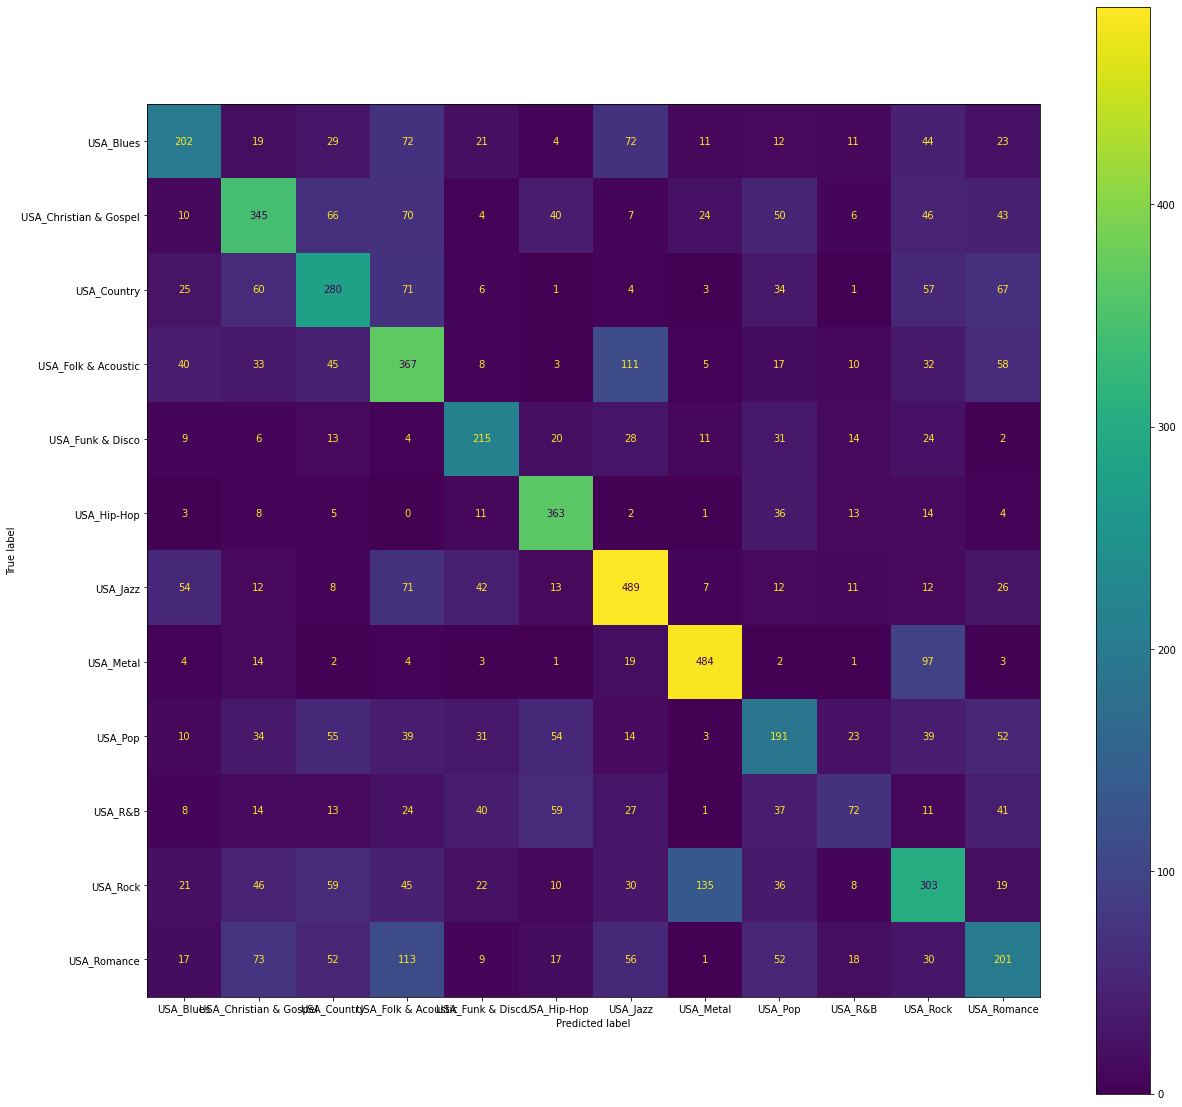

In [ ]:
plot_confusion_matrix(rfc, y_test, y_pred)

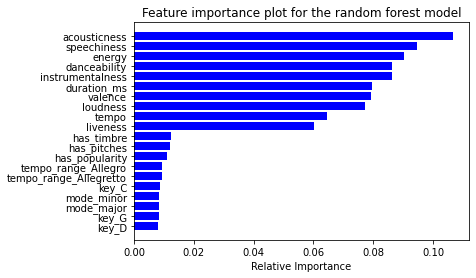

In [ ]:
plot_feature_importance_plot(rfc, X_train)

### **4.3 Add in Sentiment Analysis**

In this section, we add on text data into the model to see the model improvement. Specifically, we add sentiment score into the data.

In [ ]:
X = df_sentiment.drop(columns = ['genre', 'track_id', 'track_name', 'artist_name', 'lyrics', 'clean_lyrics'])
y = df_sentiment['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    test_size = 0.25, random_state = 545)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rfc.predict(X_test)
get_accuracy(y_test, y_pred)

Accuracy of this model: 60.15%


In [ ]:
plot_classification_report(y_test, y_pred)

                        precision    recall  f1-score   support

             USA_Blues       0.71      0.69      0.70       743
USA_Christian & Gospel       0.60      0.49      0.54       711
           USA_Country       0.47      0.48      0.47       609
   USA_Folk & Acoustic       0.56      0.65      0.60       910
      USA_Funk & Disco       0.66      0.76      0.70       520
           USA_Hip-Hop       0.62      0.75      0.68       460
              USA_Jazz       0.74      0.79      0.76      1015
             USA_Metal       0.76      0.85      0.80       773
               USA_Pop       0.41      0.37      0.38       545
               USA_R&B       0.43      0.19      0.26       347
              USA_Rock       0.45      0.39      0.42       733
           USA_Romance       0.53      0.52      0.53       741

              accuracy                           0.60      8107
             macro avg       0.58      0.58      0.57      8107
          weighted avg       0.59     

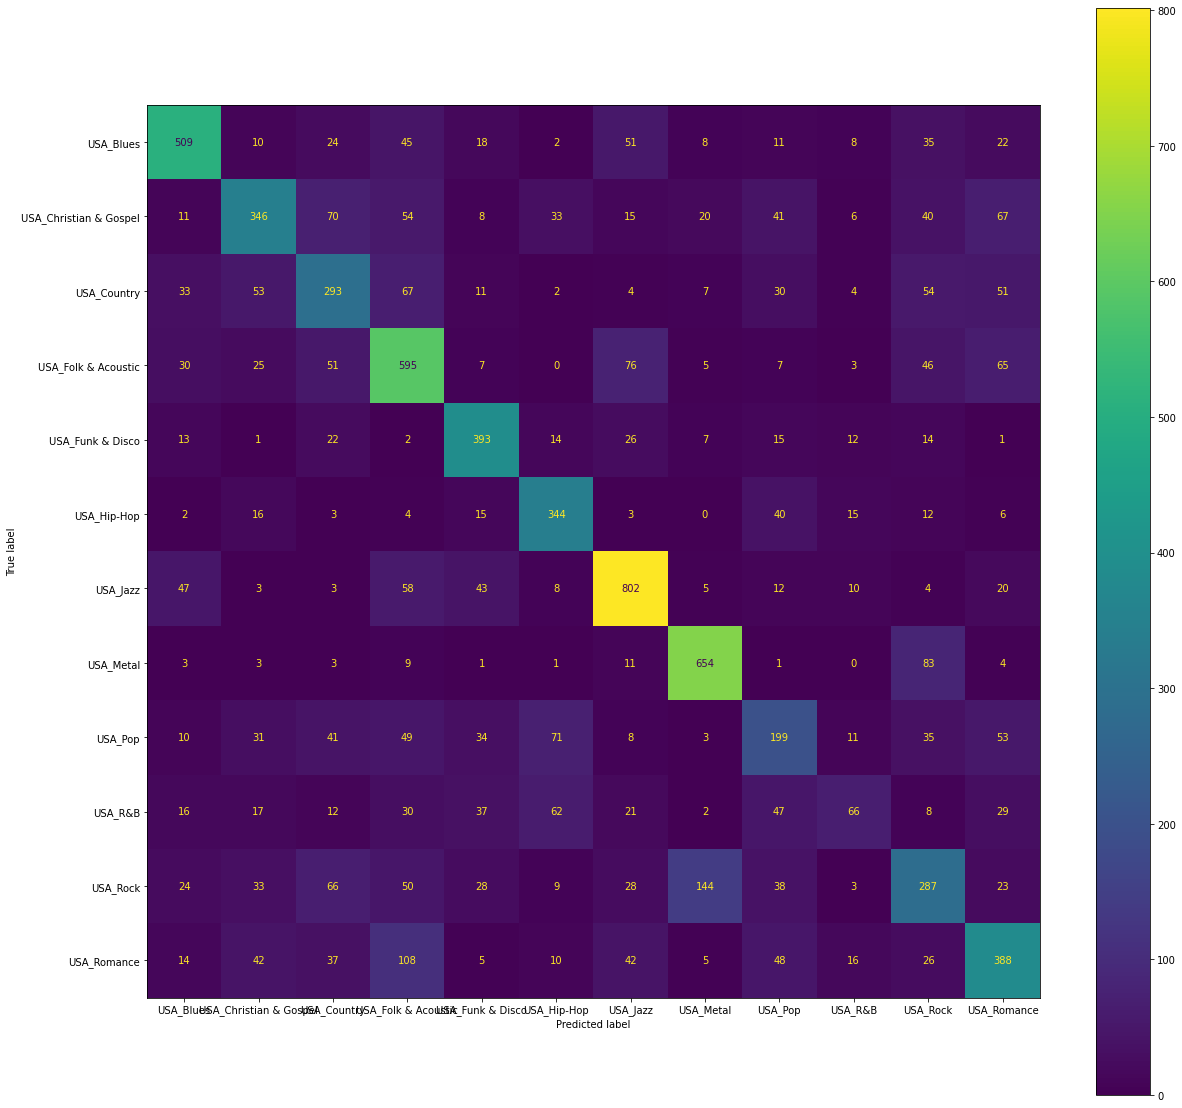

In [ ]:
plot_confusion_matrix(rfc, y_test, y_pred)

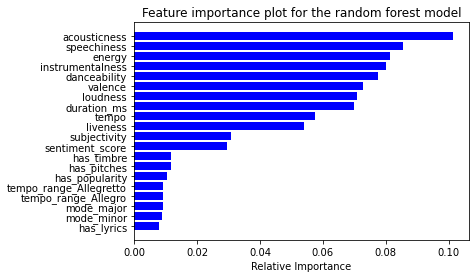

In [ ]:
plot_feature_importance_plot(rfc, X_train)

### **4.4 Add in Topic Modeling**

In this section, we add on text data into the model to see the model improvement. Specifically, we add topic modeling ranking into the data.

In [ ]:
X = df_topic.drop(columns = ['genre', 'track_id', 'track_name', 'artist_name', 'lyrics', 'clean_lyrics']).fillna(0)
y = df_topic['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    test_size = 0.25, random_state = 545)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rfc.predict(X_test)
get_accuracy(y_test, y_pred)

Accuracy of this model: 68.93%


In [ ]:
plot_classification_report(y_test, y_pred)

                        precision    recall  f1-score   support

             USA_Blues       0.80      0.78      0.79       743
USA_Christian & Gospel       0.58      0.49      0.53       711
           USA_Country       0.47      0.46      0.47       609
   USA_Folk & Acoustic       0.59      0.78      0.67       910
      USA_Funk & Disco       0.80      0.84      0.82       520
           USA_Hip-Hop       0.65      0.80      0.72       460
              USA_Jazz       0.86      0.85      0.85      1015
             USA_Metal       0.93      0.94      0.93       773
               USA_Pop       0.43      0.41      0.42       545
               USA_R&B       0.55      0.22      0.32       347
              USA_Rock       0.61      0.62      0.62       733
           USA_Romance       0.78      0.69      0.73       741

              accuracy                           0.69      8107
             macro avg       0.67      0.66      0.66      8107
          weighted avg       0.69     

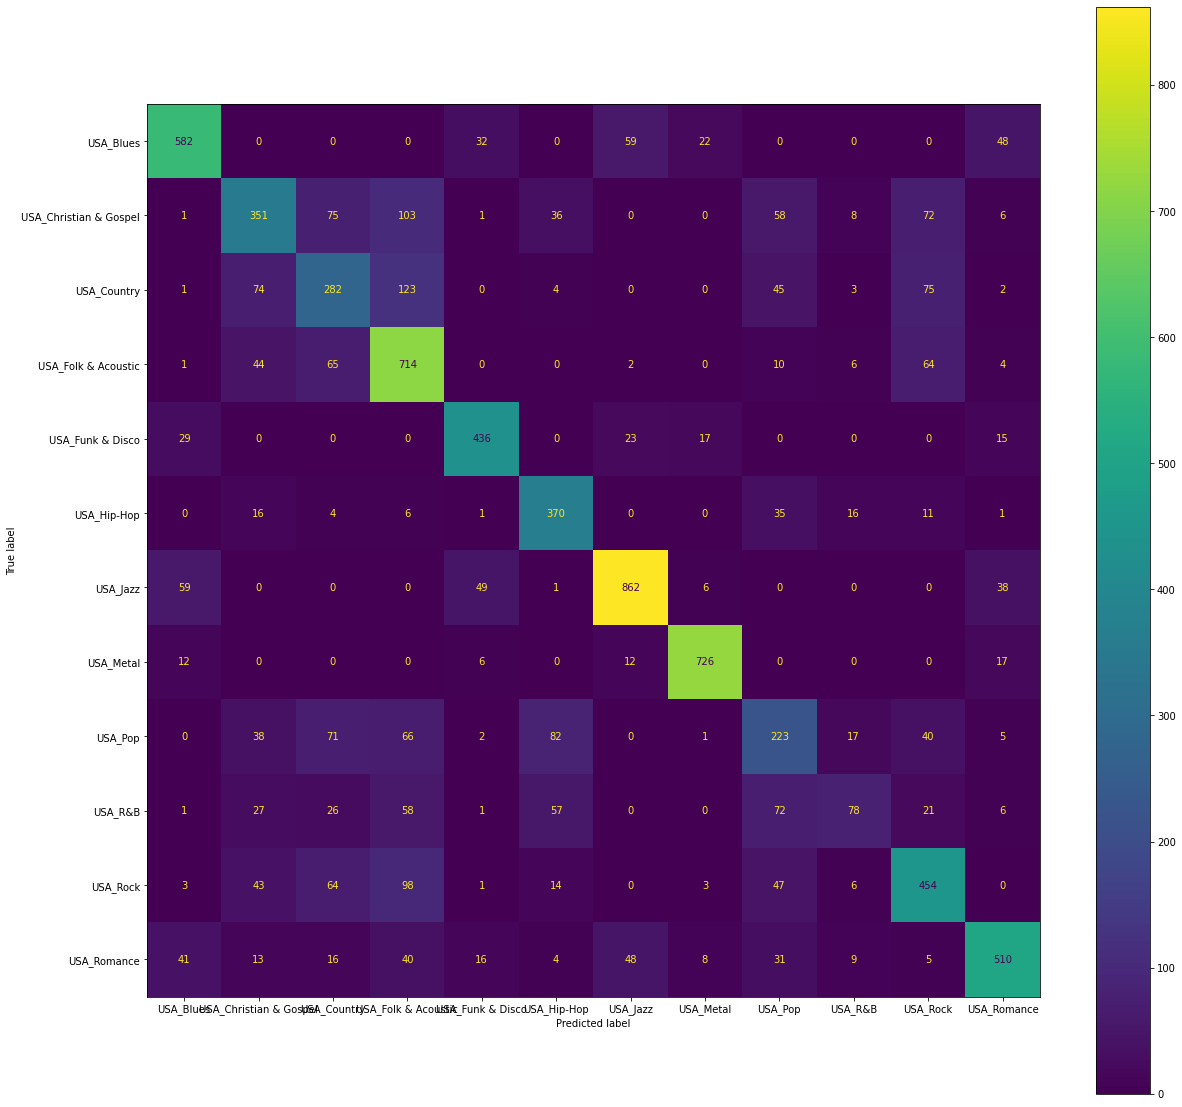

In [ ]:
plot_confusion_matrix(rfc, y_test, y_pred)

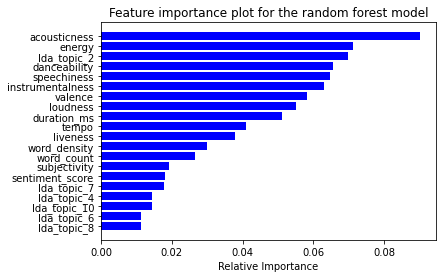

In [ ]:
plot_feature_importance_plot(rfc, X_train)

### **4.5 Impute Missing Value**

Since there are songs without lyrics, instead of imputing with zeros, let's see the result of imputing using MICE algorithm.

In [ ]:
X = df_imputed.drop(columns = ['genre', 'track_id'])
y = df_imputed['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                    test_size = 0.25, random_state = 545)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rfc.predict(X_test)
get_accuracy(y_test, y_pred)

Accuracy of this model: 45.11%


In [ ]:
plot_classification_report(y_test, y_pred)

                        precision    recall  f1-score   support

             USA_Blues       0.45      0.36      0.40       743
USA_Christian & Gospel       0.41      0.38      0.40       711
           USA_Country       0.38      0.40      0.39       609
   USA_Folk & Acoustic       0.37      0.43      0.40       910
      USA_Funk & Disco       0.46      0.55      0.50       520
           USA_Hip-Hop       0.52      0.72      0.61       460
              USA_Jazz       0.54      0.68      0.60      1015
             USA_Metal       0.67      0.76      0.71       773
               USA_Pop       0.31      0.26      0.28       545
               USA_R&B       0.33      0.08      0.13       347
              USA_Rock       0.35      0.29      0.31       733
           USA_Romance       0.37      0.29      0.32       741

              accuracy                           0.45      8107
             macro avg       0.43      0.43      0.42      8107
          weighted avg       0.44     

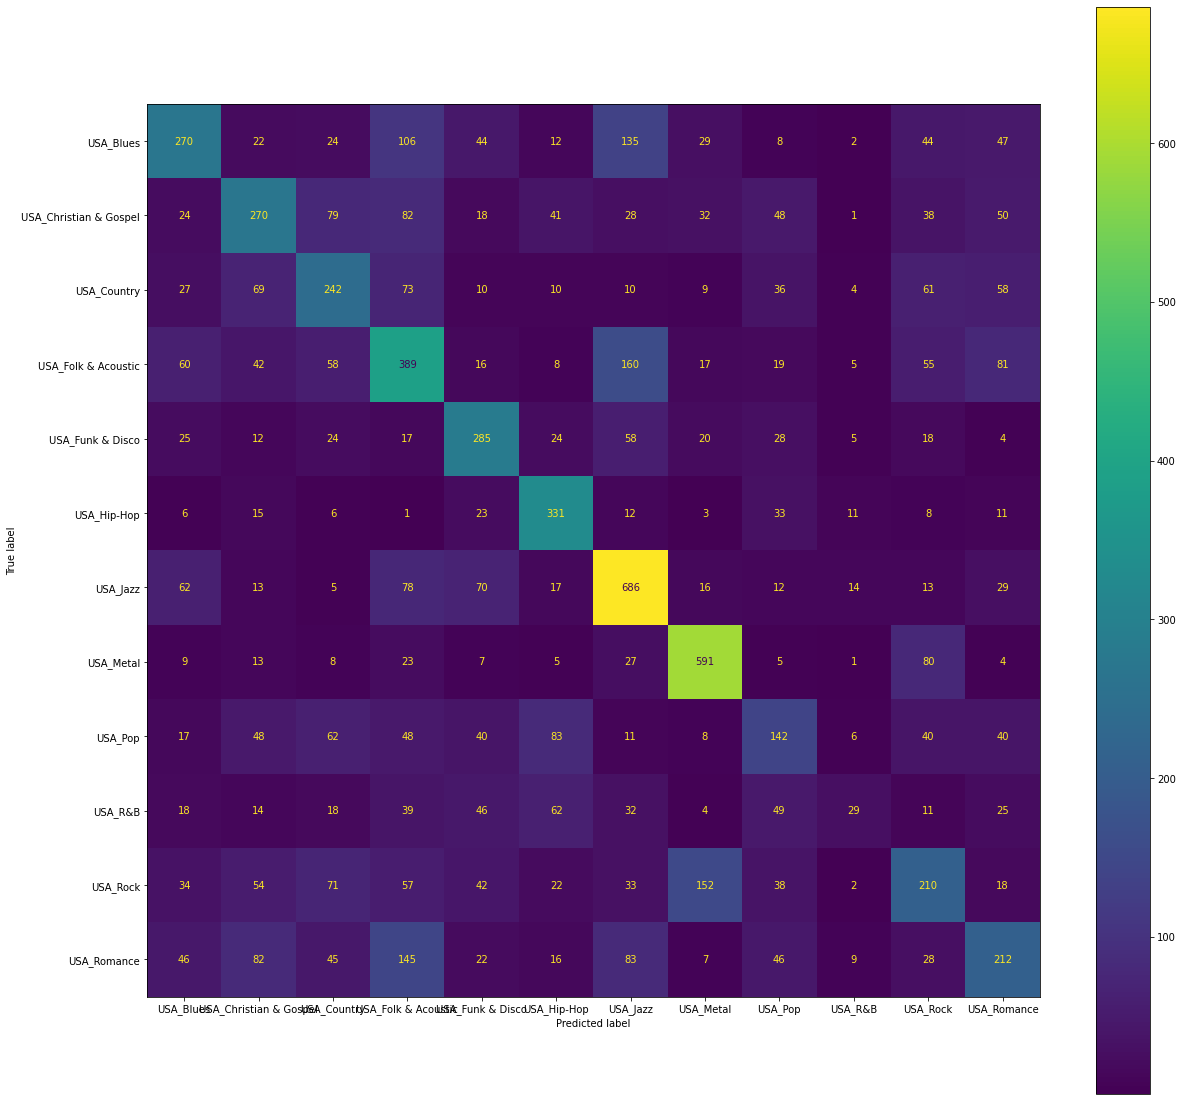

In [ ]:
plot_confusion_matrix(rfc, y_test, y_pred)

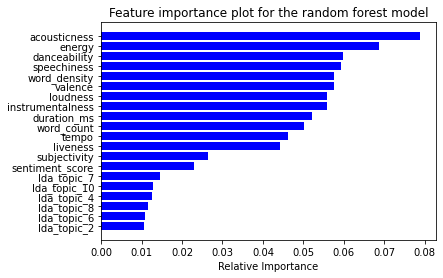

In [ ]:
plot_feature_importance_plot(rfc, X_train)

# **Potential Next Steps**

1. In this notebook, we try different dataset with the baseline, untuned Random Forest model. We can try to make use of different models such as **Lightgbm**, **XGBoost**, **Linear Model**, etc and perform model stacking to get the optimal result.

2. In the meantime, we can run gridsearch to find the best set of parameters that maximize the result.

3. Audio wave is one of the key elements that forms a song, and categorizes it into genres. Next we can try to parse youtube audio file and do some audio wave analysis, and see how this data can improve the performance. 


# **Final Summary**

From the analysis, we can summarize the result as following.


Num# | Model | Accuracy | F1-score| Top 3 Recall labels| Top 3 Precision labels| Top 3 important features
:------:|:------:|:-------:|:-------:|:-------:|:-------:|:-------:
1 | Baseline| 49.7%| 0.48| [Hip-Hop, Metal, Jazz]| [Metal, Hip-Hop, Jazz]| [acousticness, speechiness, energy]
2 | Sentiment| 60.2%| 0.57| [Metal, Jazz, Funk & Disco]| [Metal, Jazz, Blues]| [acousticness, speechiness, energy]
3 | Topic Modeling| 68.9%| 0.66| [Metal, Jazz, Funk & Disco]| [Metal, Jazz, Funk & Disco]| [acousticess, energy, lda_topic_2]
4 | Impute Missing Value| 45.1%| 0.45| [Metal, Hip-Hop, Jazz]| [Metal, Hip-Hop & Jazz, Hip-Hop]| [acousticness, energy, danceability]


We can clearly see that model #3 (after topic modeling) performs best in terms of both accuracy and F1 score. The model using imputed data surprisingly perform worse than expected. This might be improved if we run the MICE algorithm for a longer period, or get more high-quality lyrics data that can help us to the imputation.